# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import make_scorer, auc, precision_recall_curve, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score 

import pickle

import warnings
warnings.filterwarnings('ignore')

# Loading Train, Validation, Test Data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
val = pd.read_csv('validation.csv')

X_train = train['cleaned_text'].astype(str)
X_test = test['cleaned_text'].astype(str)
X_val = val['cleaned_text'].astype(str)

y_train = (train['label'] == "spam").astype(int)
y_test = (test['label'] == "spam").astype(int)
y_val = (val['label'] == "spam").astype(int)

# Training

Looking at literature we choose the following classifiers and features for our task:

**Classifiers:** Naive Bayes, Decision Tree, Logistic Regression, Support Vector Machine.

**Features:** CountVectorizer + TF-IDF.

https://indusedu.org/pdfs/IJREISS/IJREISS_4388_87139.pdf?form=MG0AV3

https://radimrehurek.com/data_science_python/

## Creating pipelines

In [3]:
# Naive Bayes
pipeline_nb = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])

# Logistic Regression
pipeline_lr = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression())
])

# Support Vector Machine
pipeline_svm = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SVC(probability=True))
])

# Decision Tree
pipeline_dt = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', DecisionTreeClassifier())
])

## Setting grid search params

In [4]:
# Parameters for GridSearchCV
vect_params = {
    'vect__max_df': [0.75, 1],
    'vect__ngram_range': [(1, 1), (1, 2), (1,3)],
}

# Naive Bayes
parameters_nb = vect_params | {
    'tfidf__use_idf': [True, False],
    'clf__alpha': [1.0, 0.1]
}

# Logistic Regression
parameters_lr = vect_params | {
    'tfidf__use_idf': [True, False],
    'clf__C': [1, 10, 100]
}

# Support Vector Machine
parameters_svm = vect_params | {
    'tfidf__use_idf': [True, False],
    'clf__C': [1, 10,100],
    'clf__kernel': ['linear', 'rbf'],
}

# Decision Tree
parameters_dt = vect_params | {
    'tfidf__use_idf': [True, False],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_leaf': [1, 2, 4]
}

## Fit Training Data

In [5]:
# Scoring metric AUCPR
def auc_prc_score(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    return auc(recall, precision)

auc_prc = make_scorer(auc_prc_score, greater_is_better=True, needs_proba=True);

In [6]:
# Naive Bayes
grid_search_nb = GridSearchCV(pipeline_nb, parameters_nb, cv=StratifiedKFold(), n_jobs=-1, verbose=1, scoring=auc_prc)
grid_search_nb.fit(X_train, y_train)
print("Best parameters for Naive Bayes: ", grid_search_nb.best_params_)

# Logistic Regression
grid_search_lr = GridSearchCV(pipeline_lr, parameters_lr, cv=StratifiedKFold(), n_jobs=-1, verbose=1, scoring=auc_prc)
grid_search_lr.fit(X_train, y_train)
print("Best parameters for Logistic Regression: ",grid_search_lr.best_params_)

# Support Vector Machine
grid_search_svm = GridSearchCV(pipeline_svm, parameters_svm, cv=StratifiedKFold(), n_jobs=-1, verbose=1, scoring=auc_prc)
grid_search_svm.fit(X_train, y_train)
print("Best parameters for SVM: ", grid_search_svm.best_params_)

# Decision Tree
grid_search_dt = GridSearchCV(pipeline_dt, parameters_dt, cv=StratifiedKFold(), n_jobs=-1, verbose=1, scoring=auc_prc)
grid_search_dt.fit(X_train, y_train)
print("Best parameters for Decision Tree: ", grid_search_dt.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters for Naive Bayes:  {'clf__alpha': 1.0, 'tfidf__use_idf': True, 'vect__max_df': 0.75, 'vect__ngram_range': (1, 1)}
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for Logistic Regression:  {'clf__C': 1, 'tfidf__use_idf': True, 'vect__max_df': 0.75, 'vect__ngram_range': (1, 1)}
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters for SVM:  {'clf__C': 1, 'clf__kernel': 'linear', 'tfidf__use_idf': True, 'vect__max_df': 0.75, 'vect__ngram_range': (1, 1)}
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters for Decision Tree:  {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'tfidf__use_idf': True, 'vect__max_df': 0.75, 'vect__ngram_range': (1, 1)}


## Benchmark Models on Validation Data

In [7]:
models = {
    'Naive Bayes': grid_search_nb.best_estimator_,
    'Decision Tree': grid_search_dt.best_estimator_,
    'Logistic Regression': grid_search_lr.best_estimator_,
    'SVM': grid_search_svm.best_estimator_
}

for name, model in models.items():
    score = model.score(X_val, y_val)
    print(f"{name} AUCPR on validation data: {score:.2f}")

Naive Bayes AUCPR on validation data: 0.97
Decision Tree AUCPR on validation data: 0.97
Logistic Regression AUCPR on validation data: 0.97
SVM AUCPR on validation data: 0.99


## Choosing Best model

In [9]:
def gen_plot(y_test, y_pred, name):
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    plt.matshow(confusion_matrix(y_test, y_pred), cmap=plt.cm.binary, interpolation='nearest')
    plt.title('confusion matrix')
    plt.colorbar()
    plt.ylabel('expected label')
    plt.xlabel('predicted label')

    plt.figtext(-0.2, 0.60, name, horizontalalignment='center', fontsize=12)
    plt.figtext(-0.2, 0.49, f"Accuracy: {accuracy:.2f}", horizontalalignment='center', fontsize=12)
    plt.figtext(-0.2, 0.45, f"Precision: {precision:.2f}", horizontalalignment='center', fontsize=12)
    plt.figtext(-0.2, 0.41, f"Recall: {recall:.2f}", horizontalalignment='center', fontsize=12)
    return [name,accuracy,precision,recall,f1]

Using critera used in google doc we choose the best model using following criteria:


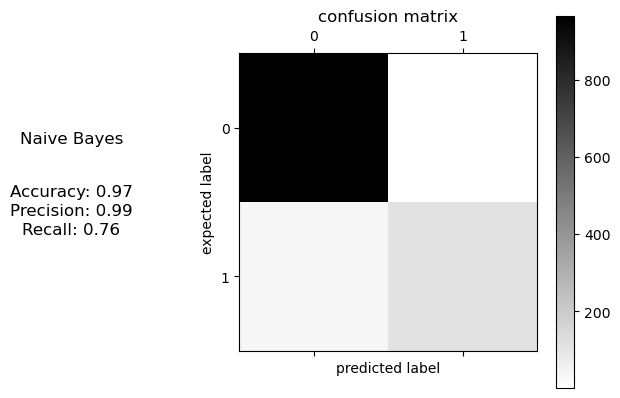

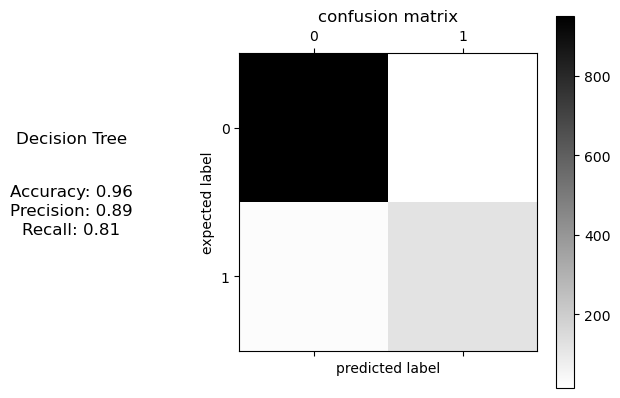

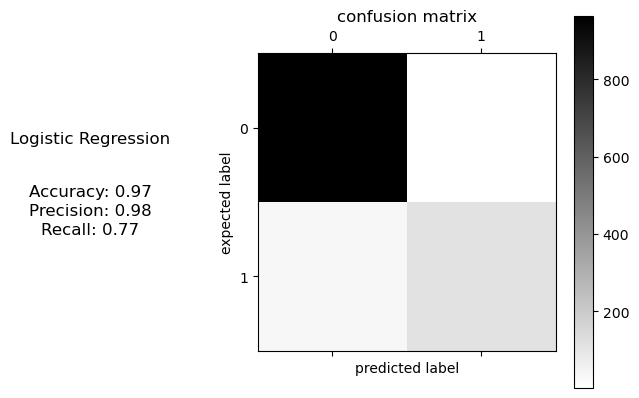

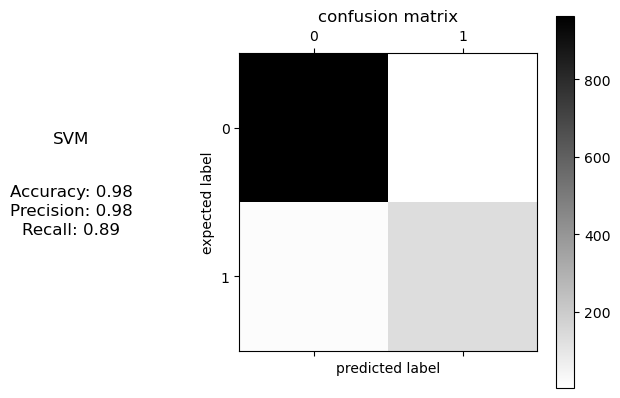

In [17]:
probabilities = {name: model.predict_proba(X_test)[:, 1] for name, model in models.items()}
preds = {name: model.predict(X_test) for name, model in models.items()}

best_model = None
best_threshold = 0.5
best_recall = 0

results = [];
for name, probs in probabilities.items():
    precision, recall, thresholds = precision_recall_curve(y_test, probs)
    y_pred = preds[name]
    
    for p, r, t in zip(precision, recall, thresholds):
        if p >= 0.90 and r > best_recall:
            best_model = models[name]
            best_threshold = t
            best_recall = r

    results.append(gen_plot(y_test, y_pred, name));

In [18]:
print("Best Model: ", best_model)
print("Optimal Threshold: ", best_threshold)

# Saving model
with open('model.pkl','wb') as f:
    pickle.dump([best_model,best_threshold],f)

Best Model:  Pipeline(steps=[('vect', CountVectorizer(max_df=0.75)),
                ('tfidf', TfidfTransformer()),
                ('clf', SVC(C=1, kernel='linear', probability=True))])
Optimal Threshold:  0.17037377367863896


In [26]:
pd.DataFrame(results, columns=['Classifier','Accuracy','Precision','Recall','F1 Score'],index=None)

,Classifier,Accuracy,Precision,Recall,F1 Score
0,Naive Bayes,0.966816,0.991228,0.758389,0.859316
1,Decision Tree,0.961435,0.889706,0.812081,0.849123
2,Logistic Regression,0.966816,0.982759,0.765101,0.860377
3,SVM,0.982063,0.977778,0.885906,0.929577


SVM seems to be our best classifier.